In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Этап №1 - Загрузка, анализ и подготовка датасета

## Загрузка данных и анализ пропусков

In [152]:
# Загрузка .xls файла
df = pd.read_excel('data_for_analysis.xlsx', index_col=0)  # Индекс - нумерация строк
print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
df.head()

Размер данных: 1001 строк, 213 столбцов


,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,...,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,...,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,...,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,...,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,...,0,0,0,0,0,0,0,0,0,0


## Анализ пропусков в целевых параметрах

На данном этапе делаем следующие операции:  
1. Копирование датасета;
2. Анализ пропусков в данных;
3. Замена пропусков в даных на нули;
4. Удаление строк с пропусками или отриательными значениями в целевых переменных.

In [153]:
# Создаем копию датасета на всякий случай, чтобы не считывать заново если в процессе накосячу :)
# А я обязательно где-то накосячу)
df_copy = df.copy()
df_clean = df.copy()

# Анализ пропусков
missing = df.isnull().sum()
print("Пропуски по столбцам:\n", missing[missing > 0])

# Заменим все пустые значения на 0
df_clean.fillna(0)

# Удаление строк с пропусками в целевых переменных (IC50/CC50/SI)
target_cols = ['IC50, mM', 'CC50, mM', 'SI']
df_clean = df.dropna(subset=target_cols)

# Фильтруем строки, удаляя те, где есть отрицательные значения в указанных столбцах
df_clean = df_clean[(df_clean['IC50, mM'] >= 0) & (df_clean['CC50, mM'] >= 0) & (df_clean['SI'] >= 0)]

Пропуски по столбцам:
 MaxPartialCharge       3
MinPartialCharge       3
MaxAbsPartialCharge    3
MinAbsPartialCharge    3
BCUT2D_MWHI            3
BCUT2D_MWLOW           3
BCUT2D_CHGHI           3
BCUT2D_CHGLO           3
BCUT2D_LOGPHI          3
BCUT2D_LOGPLOW         3
BCUT2D_MRHI            3
BCUT2D_MRLOW           3
dtype: int64


Проверим датасет на наличие полностью нулевых колонок. Их стоит откинуть.

In [156]:
# Создадим списки всех колонок в датасете и тех, которые подлежат удалению
zero_cols_to_drop = []
original_columns = list(df_clean.columns)

# цикл прохода по всем колонкам в дс
for col in original_columns:
    zero_ratio = (df_clean[col] == 0).mean()  # доля нулей в столбце
    if df_clean[col].sum() == 0:
        zero_cols_to_drop.append(col)
    else:
        pass

# Отбрасываем колонки, которые после бинаризации оказались полностью нулевыми
print(f'Спосок колонок, где все значения нулевые: {zero_cols_to_drop}')
print(f'Всего нулевых колонок: {len(zero_cols_to_drop)}') 
answ = input('Удалить пустые колонки? [Y/n]:').strip().lower()

if answ in ('y', 'yes'):
    df_clean.drop(columns=zero_cols_to_drop, inplace=True)
    print(f'{len(zero_cols_to_drop)} колонок удалены')
else:
    print('Отмена')

print(f'Размер датасета: {df_clean.shape}')

Спосок колонок, где все значения нулевые: ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_thiocyan']
Всего нулевых колонок: 18


Удалить пустые колонки? [Y/n]: y


18 колонок удалены
Размер датасета: (1001, 195)


## Бинарная трансформация тех столбцов, где пропусков в данных > 75%

Бинарная трансформация полезна для столбцов с высокой долей пропусков (или заменённых нулями значениями), потому что она позволяет явно выделить наличие или отсутствие исходных данных. Если более 75% значений в столбце отсутствуют, преобразование такого столбца в бинарный (например, 1 — признак был заполнен, 0 — был пропуск/ноль) помогает модели лучше различать важные структурные особенности данных и уменьшить влияние шума, вызванного массовыми пропусками. Такой подход также может улучшить качество предсказаний моделей, поскольку они будут оперировать более информативным признаком, отражающим сам факт пропуска информации, а не случайное или подменное значение.  

Просмотрев датасет "вручную" я обратил внимание, что в нем есть столбцы с "осмысленными" нулями, которые являются частью данных, а не пропусками. Т.е. их нельзя отбросить или заменить на медиану, т.к. эти нули - самоценны. Такие столбики пришлось отобрать вручную в отдельный список.

In [158]:
# Список колонок с которыми нужна отдельная работа
do_not_touch_columns = ['HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 
                     'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 
                     'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 
                     'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 
                     'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 
                     'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 
                     'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 
                     'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 
                     'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 
                     'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 
                     'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 
                     'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 
                     'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea']

Далее - код, производящий бинарную трансформацию.

In [160]:
# Cоздаем списки оригинальных и измененных колонок
transformed_cols = []  
original_columns = list(df_clean.columns)
work_columns = [x for x in original_columns if x not in do_not_touch_columns]

# В жтом цикле проходим по всем колонкам и если доля нулевых значений > 75% - производим бинарищацию
for col in work_columns:
    zero_ratio = (df_clean[col] == 0).mean()  # доля нулей в столбце
    if zero_ratio > 0.75:
        # бинаризуем: 1 — ненулевое, 0 — ноль
        df_clean[col] = (df_clean[col] != 0).astype(int)
        transformed_cols.append((col, zero_ratio))

# Формируем отчет
print(f"▶ Преобразовано столбцов: {len(transformed_cols)}")
if transformed_cols:
    print("Детали:")
    for col, ratio in transformed_cols:
        print(f"- '{col}': {round(ratio*100,1)}% нулей")
else:
    print("Столбцы с >75% нулей не найдены")

df_clean.shape

▶ Преобразовано столбцов: 8
Детали:
- 'PEOE_VSA13': 81.5% нулей
- 'PEOE_VSA4': 79.5% нулей
- 'PEOE_VSA5': 83.4% нулей
- 'SMR_VSA2': 98.9% нулей
- 'SlogP_VSA7': 94.5% нулей
- 'EState_VSA11': 97.4% нулей
- 'VSA_EState10': 75.0% нулей
- 'VSA_EState9': 75.5% нулей


(1001, 195)

## Заполнение пропусков в данных медианой

Замена пропусков в данных полезна при анализе датасета, потому что позволяет сохранить максимальное количество информации, не теряя значимых наблюдений из-за отсутствующих значений. Такой подход помогает предотвратить снижение объёма выборки и потенциальное искажение результатов, как это бывает при удалении строк с пропусками. Замена может быть предпочтительной, потому что корректно проведённый процесс замены поддерживает целостность и корректность анализа, снижая влияние пропусков на итоговые выводы и повышая устойчивость моделей машинного обучения.

Заменять пропуски медианой будем только в том случае, если пропусков меньше 75%.  

In [162]:
# Cоздаем список колонок
all_columns = list(df_clean.columns)
work_columns = [x for x in original_columns if x not in do_not_touch_columns]

# Цикл, в котором прлходим по всем столбцам и там, где количество нулевых значений меньше 75% заменяем проспуски на медиану 
for col in all_columns:
    zero_ratio = (df_clean[col] == 0).mean()  # доля нулей в столбце
    if zero_ratio < 0.75:
        median_value = df_clean[col].median()  # вычисляем медиану
        df_clean[col] = df_clean[col].replace(0, median_value)

df_clean.shape

(1001, 195)

In [164]:
df_clean.head()

,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,...,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,...,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,...,2,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,...,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,...,0,0,0,0,0,0,0,0,0,0


## Логарифмирование данных

Логарифмирование данных в датасете полезно тем, что позволяет уменьшить влияние выбросов, нормализовать распределение и сделать его ближе к нормальному, а также улучшить масштабируемость признаков, что положительно сказывается на работе многих статистических моделей и алгоритмов машинного обучения. Однако логарифмическая функция определена только для положительных значений, поэтому важно отбросить или обработать отрицательные значения в данных заранее, чтобы избежать ошибок и некорректных результатов при трансформации.

In [166]:
# Составим два списка по наличию отрицательных значений
columns_with_negatives = []
columns_without_negatives = []

for col in df_clean.columns:
    if col in do_not_touch_columns:
        continue
    if (df_clean[col] < 0).any():
        columns_with_negatives.append(col)
    else:
        columns_without_negatives.append(col)

In [168]:
print(columns_with_negatives)

['MinEStateIndex', 'MaxPartialCharge', 'MinPartialCharge', 'BCUT2D_CHGLO', 'BCUT2D_LOGPLOW', 'BCUT2D_MRLOW', 'HallKierAlpha', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'MolLogP']


In [170]:
# Логарифмируем столбцы без отрицательных значений, добавляя новые столбцы справа
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
for col in columns_without_negatives:
    log_col = f"{col} log10"
    insert_at = df_clean.columns.get_loc(col) + 1
    log_values = np.where(df_clean[col] == 0, 0, np.log10(df_clean[col]))
    df_clean.insert(insert_at, log_col, log_values)

df_clean = df_clean.copy()

C:\Users\kaba-\AppData\Local\Temp\ipykernel_7756\839389373.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean.insert(insert_at, log_col, log_values)
C:\Users\kaba-\AppData\Local\Temp\ipykernel_7756\839389373.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean.insert(insert_at, log_col, log_values)
C:\Users\kaba-\AppData\Local\Temp\ipykernel_7756\839389373.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Для данных, содержащих отрицательные значения, стандартное логарифмирование невозможно, поскольку логарифм определён только для положительных чисел. Однако можно воспользоваться логарифмом с сохранением знака, чтобы обойти это ограничение. На выходе мы получим более нормализованное распределение, но с сохранением знака.

In [172]:
# Логарифмируем с сохранением знака столбцы с отрицательными значениями, добавляя новые столбцы справа
# функция логарифмирования с сохранением знака ()
def log10_with_sign(x):
    return np.sign(x) * np.log10(np.abs(x) + 1)

for col in columns_with_negatives:
    new_col = f"{col}_log10_sign"
    # Логарифмируем значения столбца
    df_clean[new_col] = log10_with_sign(df_clean[col])
    # Определяем позицию текущей колонки
    col_idx = df_clean.columns.get_loc(col)
    # Получаем все имена колонок
    cols = list(df_clean.columns)
    # Удаляем новый столбец из конца и вставляем после оригинального
    cols.remove(new_col)
    cols.insert(col_idx + 1, new_col)
    # Переупорядочиваем DataFrame
    df_clean = df_clean[cols]

df_clean = df_clean.copy()
df_clean.fillna(0, inplace=True)

In [174]:
# Сохраняем
df_clean.to_excel('processed_data.xlsx', index=False)

# Этап №2 исследование датасета

## Загрузка датасета и распределение исследуемых признаков

In [176]:
# Загрузка .xls файла
data = pd.read_excel('processed_data.xlsx')  # Индекс - нумерация строк
print(f"Размер данных: {data.shape[0]} строк, {data.shape[1]} столбцов")
data.head()

Размер данных: 1001 строк, 303 столбцов


,"IC50, mM","IC50, mM log10","CC50, mM","CC50, mM log10",SI,SI log10,MaxAbsEStateIndex,MaxAbsEStateIndex log10,MaxEStateIndex,MaxEStateIndex log10,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,0.795141,175.482382,2.244234,28.125000,1.449093,5.094096,0.707067,5.094096,0.707067,...,0,0,0,0,0,0,0,0,3,0
1,0.771831,-0.112478,5.402819,0.732620,7.000000,0.845098,3.961417,0.597851,3.961417,0.597851,...,0,0,0,0,0,0,0,0,3,0
2,223.808778,2.349877,161.142320,2.207210,0.720000,-0.142668,2.627117,0.419479,2.627117,0.419479,...,2,0,0,0,0,0,0,0,3,0
3,1.705624,0.231883,107.855654,2.032843,63.235294,1.800960,5.097360,0.707345,5.097360,0.707345,...,0,0,0,0,0,0,0,0,4,0
4,107.131532,2.029917,139.270991,2.143861,1.300000,0.113943,5.150510,0.711850,5.150510,0.711850,...,0,0,0,0,0,0,0,0,0,0


Далее выведем графики распределения для целевых переменных. Выводить будем по парам вместе с логарифмированной переменной.

<Figure size 1200x800 with 0 Axes>

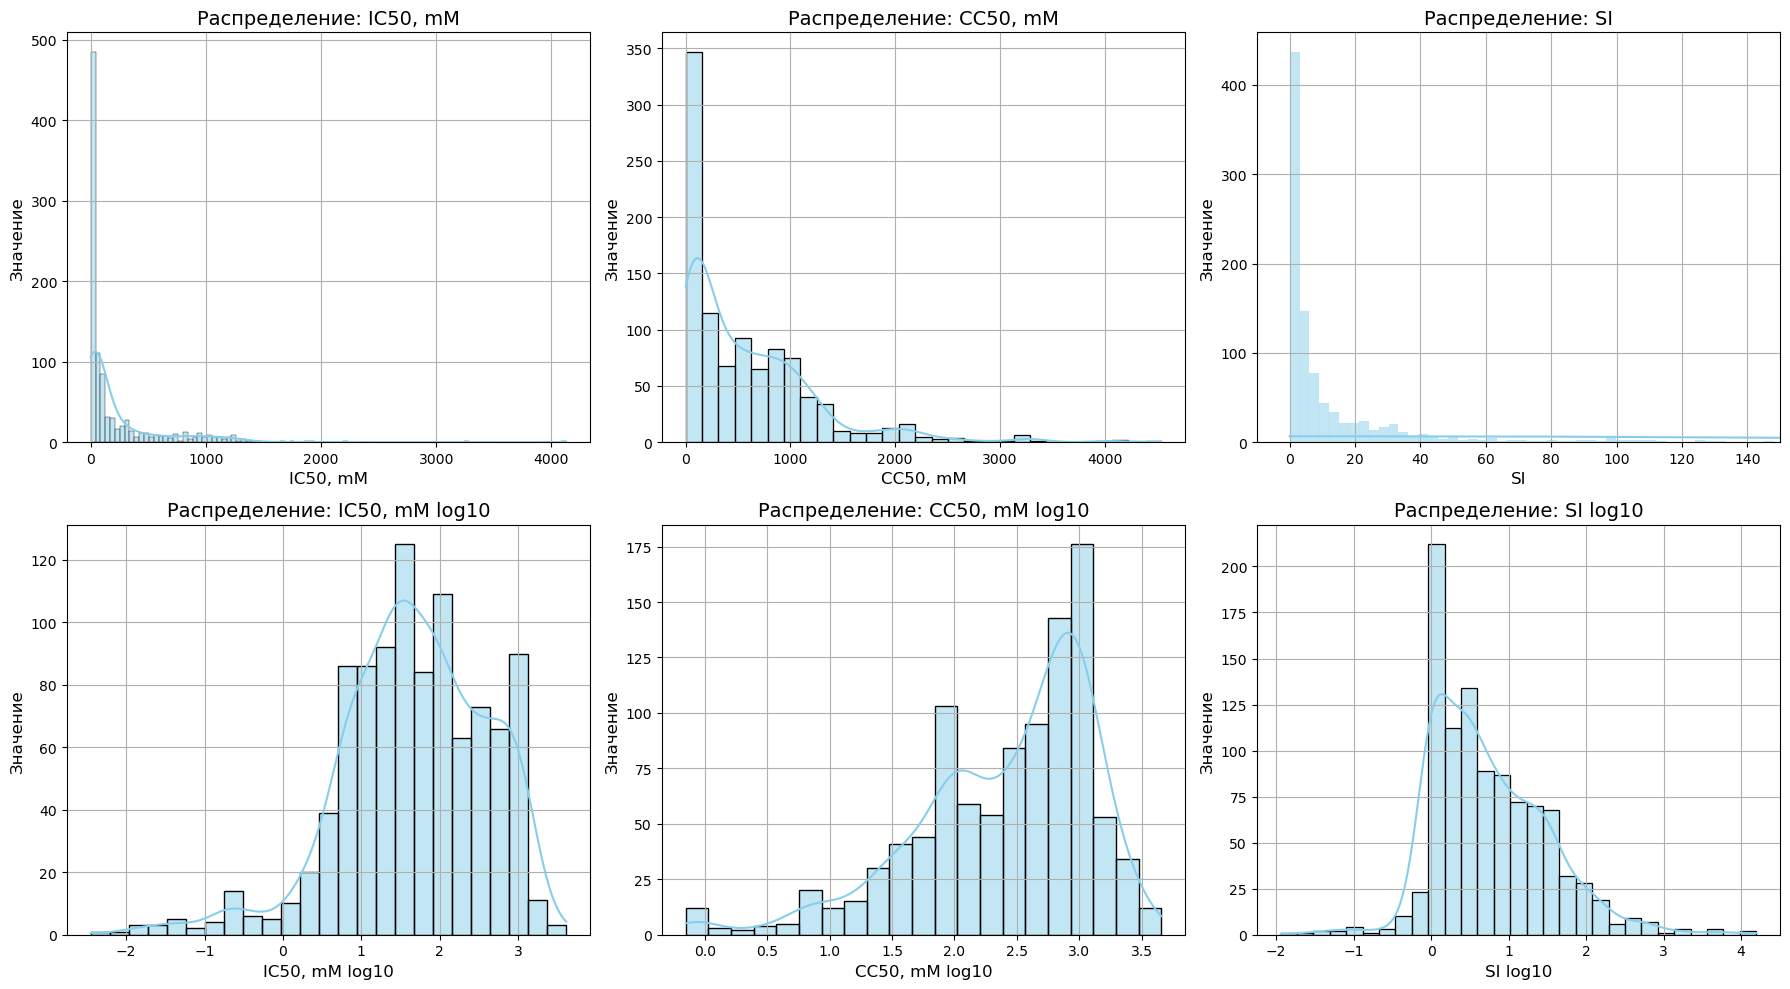

In [178]:
# построим фигуру для вывода распределений
plt.figure(figsize=(12, 8))
columns = ['IC50, mM', 'CC50, mM', 'SI', 'IC50, mM log10', 'CC50, mM log10', 'SI log10']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  #  массив для удобства итерации

# цикл, в котором проходим по каждой из колонок 
for i, col in enumerate(columns):
    ax = axes[i]
    # График распределения
    sns.histplot(data[col], kde=True, ax=ax, color='skyblue')
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Значение", fontsize=12)
    ax.set_title(f'Распределение: {col}', fontsize=14)
    ax.grid(True)

    # Ограничение осей по X для колонки SI, т.к.та имеет сильную левостороннюю асимметрию
    if col == 'SI':
        ax.set_xlim(-10, 150)  

plt.tight_layout()
plt.show()

Как видно из представленного выше изображения, исходные данные демонстрируют значительные искажения, причем значительная часть значений сосредоточена вблизи нуля. У переменной "SI" настолько большой правый хвост, что пришлось его искуственно ограничивать, т.к. тот "ломал" график и последний становился неинформативным. Для улучшения наглядности график распределения "SI" будет представлен отдельно ниже.

Логарифмирование целевых переменных способствовало улучшению симметрии распределения и его приближению к нормальному. В дальнейшем, в процессе обучения моделей, мы будем опираться на логарифмированные целевые переменные, так как большинство моделей демонстрируют свои худшие результаты при работе с данными, обладающими выраженной асимметрией.

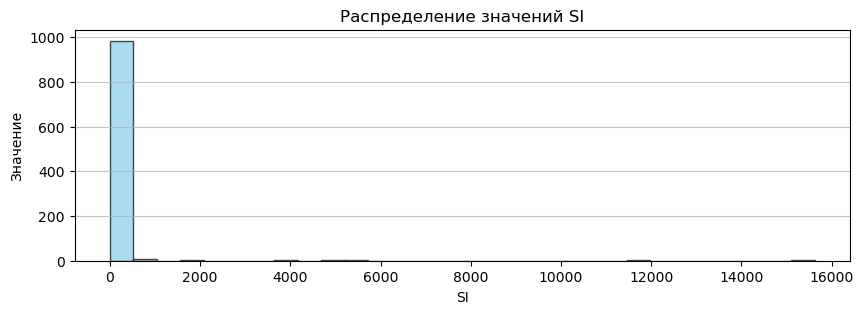

In [180]:
plt.figure(figsize=(10, 3))
plt.hist(data['SI'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Назначим заголовки и метки осей
plt.title('Распределение значений SI')
plt.xlabel('SI')  # Название оси X
plt.ylabel('Значение')  # Название оси Y

# Отобразим график
plt.grid(axis='y', alpha=0.75)
plt.show()

Как видно, "SI" имеет длинный "хвост". При этом, практически все значения находятся в диапазоне от 0 до 1000.

## Исследование корреляций

На следующем этапе мы приступим к анализу взаимосвязей между признаками с целью выявить те из них, чьи изменения оказывают наибольшее влияние на изучаемый параметр. Для этого в среде Pandas используется встроенный метод corr(), позволяющий вычислить коэффициенты корреляции между парами исследуемых переменных. По полученным значениям можно отобрать параметры с самыми высокими по модулю корреляциями. Для наглядности полученные результаты будут визуализированы.

In [195]:
# Список целевых переменных
target_columns = ['IC50, mM', 'CC50, mM', 'SI', 'IC50, mM log10', 'CC50, mM log10', 'SI log10']

# Словарь с 25 самыми коррелирующими для каждого признака
most_correlated = {}

# Цикл, в котором проходим по каждому признаку
for target in target_columns:
    # Считаем корреляции с остальными столбцами (исключая целевые)
    correlations = data.corr()[target].drop(labels=target_columns)
    # Сортируем по абсолютному значению корреляции по убыванию и берем top-20
    top_corrs = correlations.abs().sort_values(ascending=False).head(25)
    # Сохраняем имена и значения корреляций
    most_correlated[target] = correlations.loc[top_corrs.index]

# Вывод
for target, corrs in most_correlated.items():
    print(f'\nДля "{target}" больше всего коррелируют следующие 25 столбцов:')
    for col, value in corrs.items():
        print(f'  {col}: коэффициент корреляции {value:.3f}')


Для "IC50, mM" больше всего коррелируют следующие 25 столбцов:
  PEOE_VSA7 log10: коэффициент корреляции -0.343
  Chi2n log10: коэффициент корреляции -0.312
  Chi3n log10: коэффициент корреляции -0.301
  Chi4n log10: коэффициент корреляции -0.299
  Chi2v log10: коэффициент корреляции -0.288
  Chi4v log10: коэффициент корреляции -0.286
  Chi3v log10: коэффициент корреляции -0.285
  VSA_EState4_log10_sign: коэффициент корреляции -0.278
  Chi1n log10: коэффициент корреляции -0.277
  PEOE_VSA7: коэффициент корреляции -0.266
  VSA_EState4: коэффициент корреляции -0.263
  Chi2n: коэффициент корреляции -0.257
  Chi1v log10: коэффициент корреляции -0.255
  SlogP_VSA5 log10: коэффициент корреляции -0.250
  MolMR log10: коэффициент корреляции -0.250
  Chi0n log10: коэффициент корреляции -0.249
  Chi2v: коэффициент корреляции -0.249
  fr_Nhpyrrole: коэффициент корреляции 0.246
  fr_Ar_NH: коэффициент корреляции 0.246
  Chi4v: коэффициент корреляции -0.244
  Chi4n: коэффициент корреляции -0.243
 

Удивительно, но коэффициенты корреляции целевых переменных до логарифмирования оказываются выше, чем после него.  
Вероятно это связано с тем, что после логарифмирования снизилась роль выбросов, которые "тянули" ковариацию вверх, т.к. логарифм стремится уменьшить влияние крупных значений и выбросов, выравнивая распределение по масштабу.  
Также коэффициент корреляции показывает только линейную связь. При логарифмировании меняется характер связи. 

### Корреляции для признака "IC50"

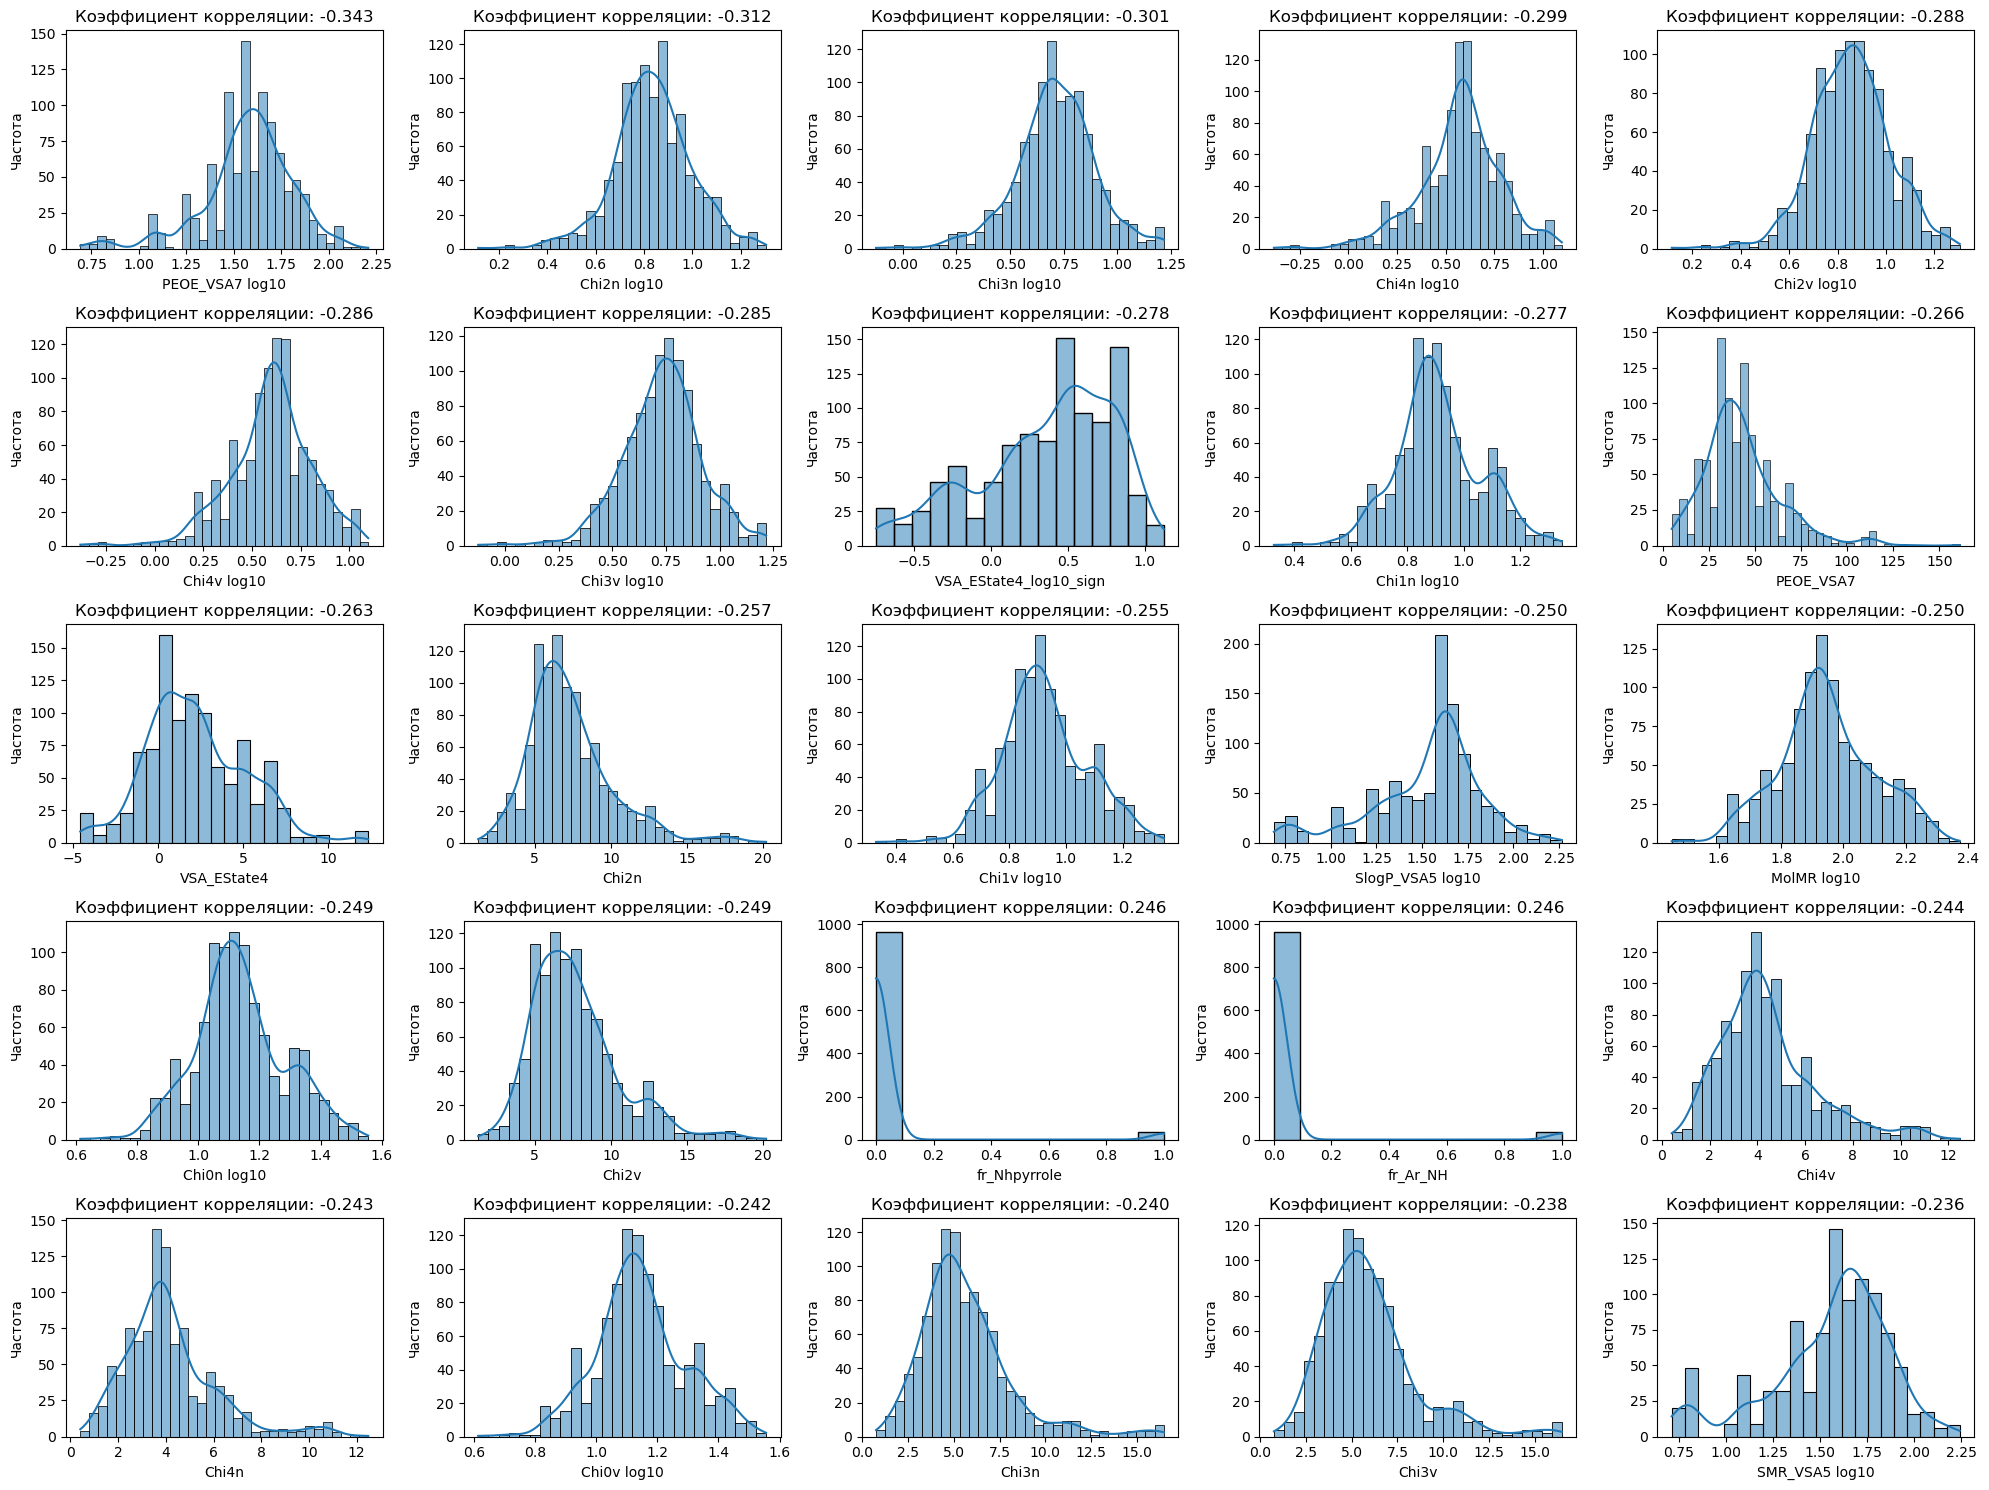

In [49]:
variable_names = list(most_correlated['IC50, mM'].keys())
num_variables = len(variable_names)

# Создаём фигуру и оси для графиков
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()

# Строим графики
for i, variable in enumerate(variable_names):
    ax = axes[i]
    
    # Строим график распределения
    sns.histplot(data[variable], ax=ax, kde=True)
    ax.set_title(f'Коэффициент корреляции: {most_correlated['IC50, mM'][variable]:.3f}')
    ax.set_xlabel(variable)
    ax.set_ylabel('Частота')

# Выводим
plt.tight_layout()
plt.show()

Как видно выше - большинство признаков имеют красивое практически нормальное распределение.

### Корреляции для признака "IC50, mM log10"

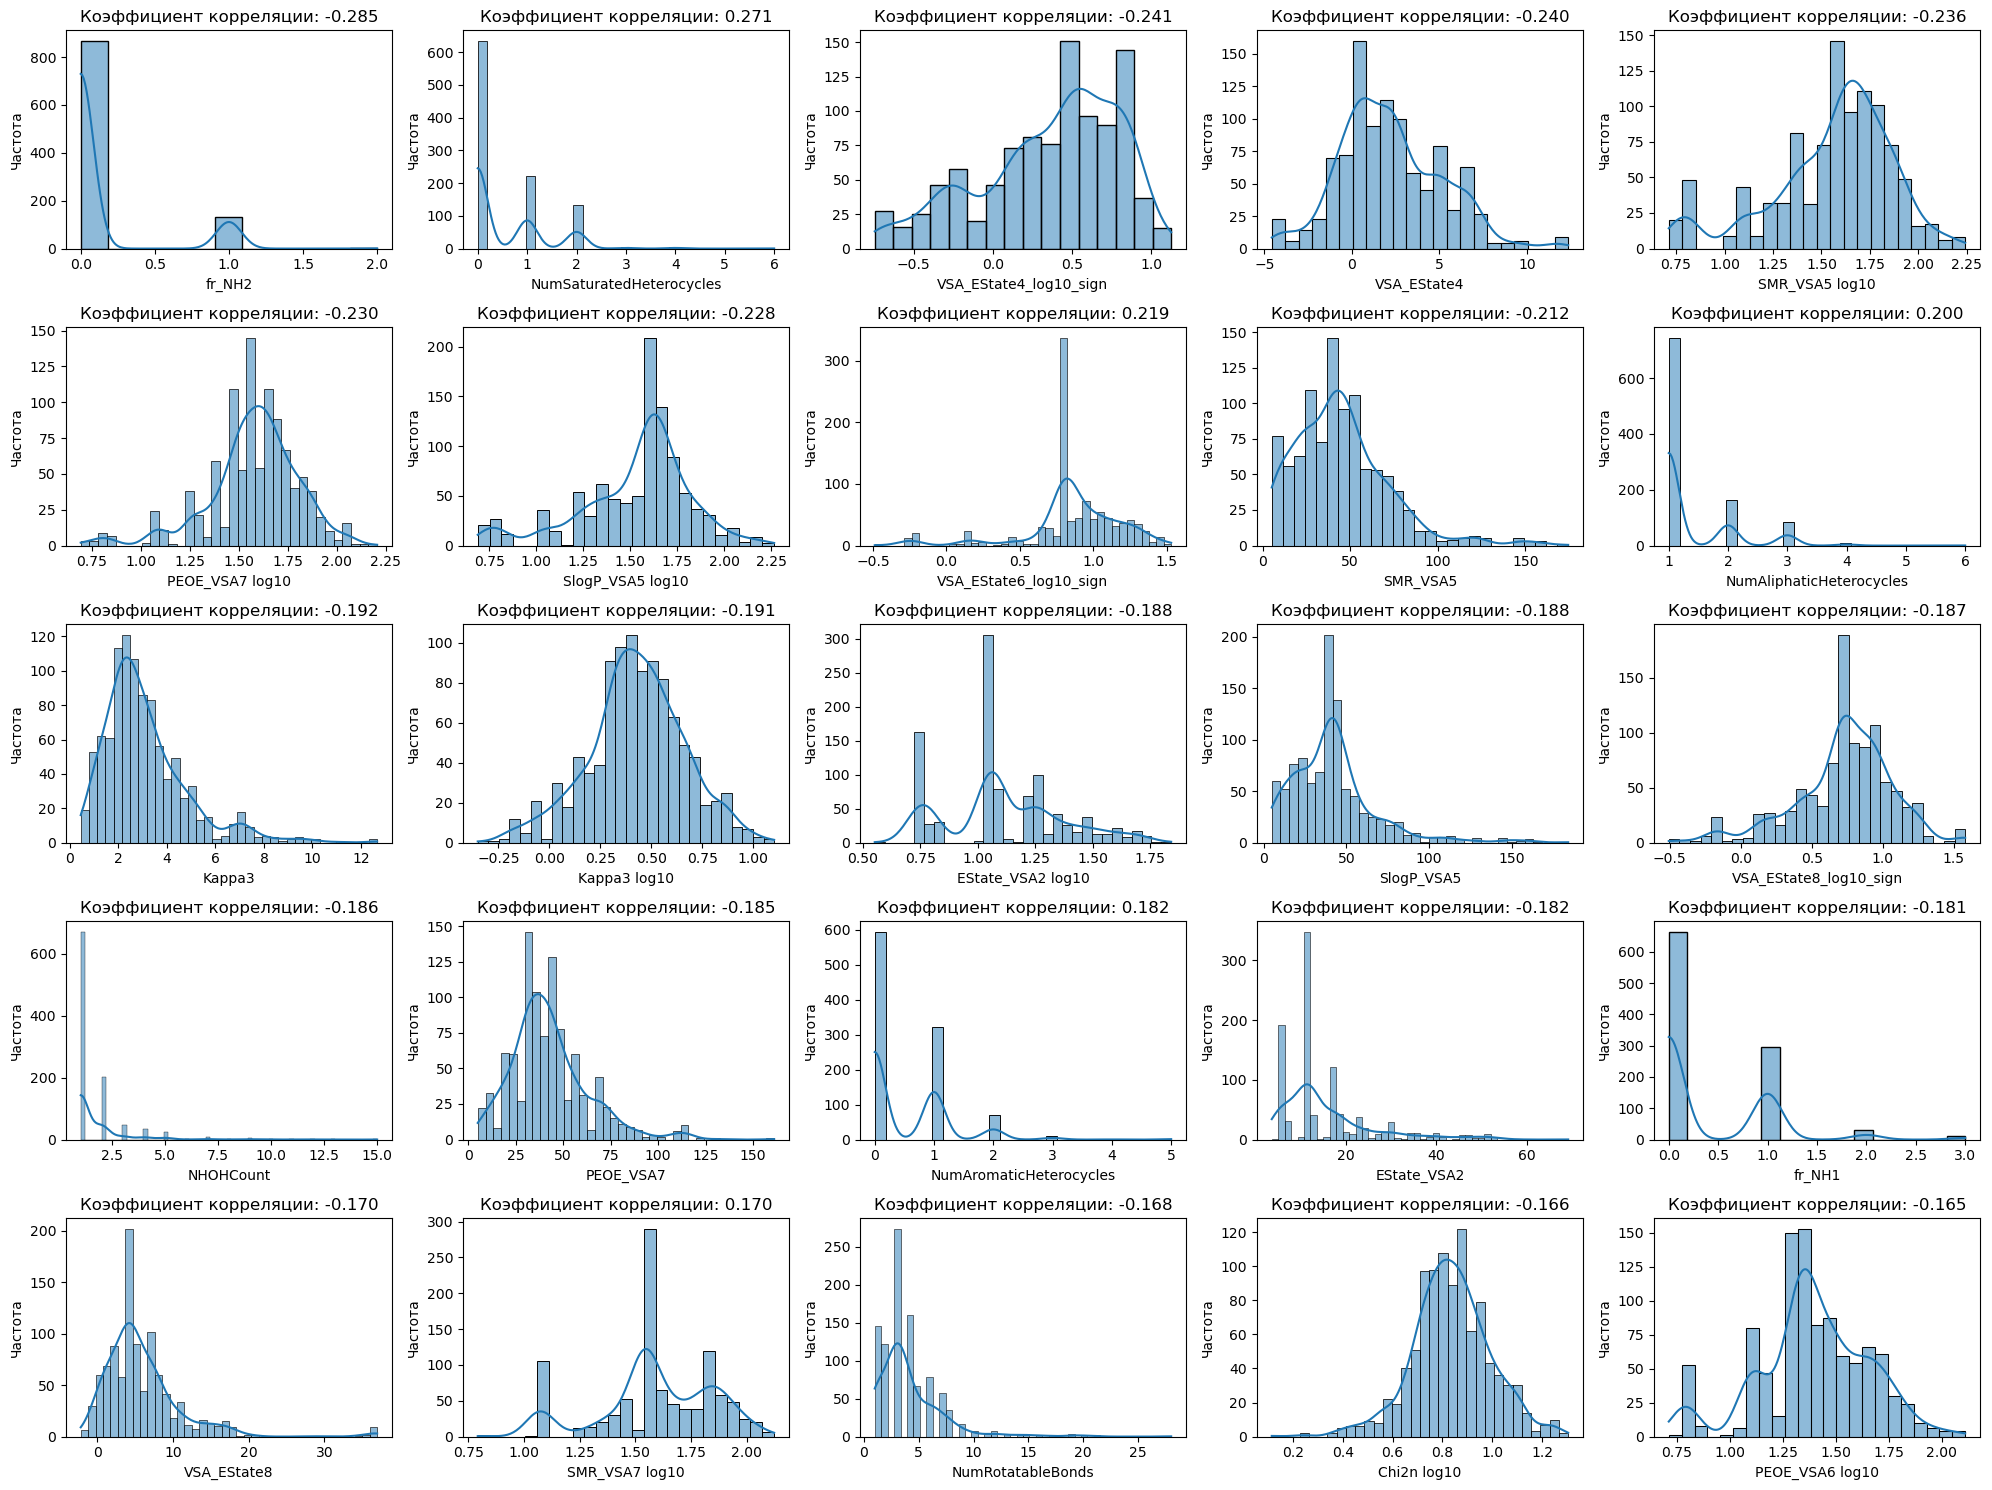

In [190]:
variable_names = list(most_correlated['IC50, mM log10'].keys())
num_variables = len(variable_names)

# Создаём фигуру и оси для графиков
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()

# Строим графики
for i, variable in enumerate(variable_names):
    ax = axes[i]
    
    # Строим график распределения
    sns.histplot(data[variable], ax=ax, kde=True)
    ax.set_title(f'Коэффициент корреляции: {most_correlated['IC50, mM log10'][variable]:.3f}')
    ax.set_xlabel(variable)
    ax.set_ylabel('Частота')

# Выводим
plt.tight_layout()
plt.show()

### Корреляции для признака "CC50, mM"

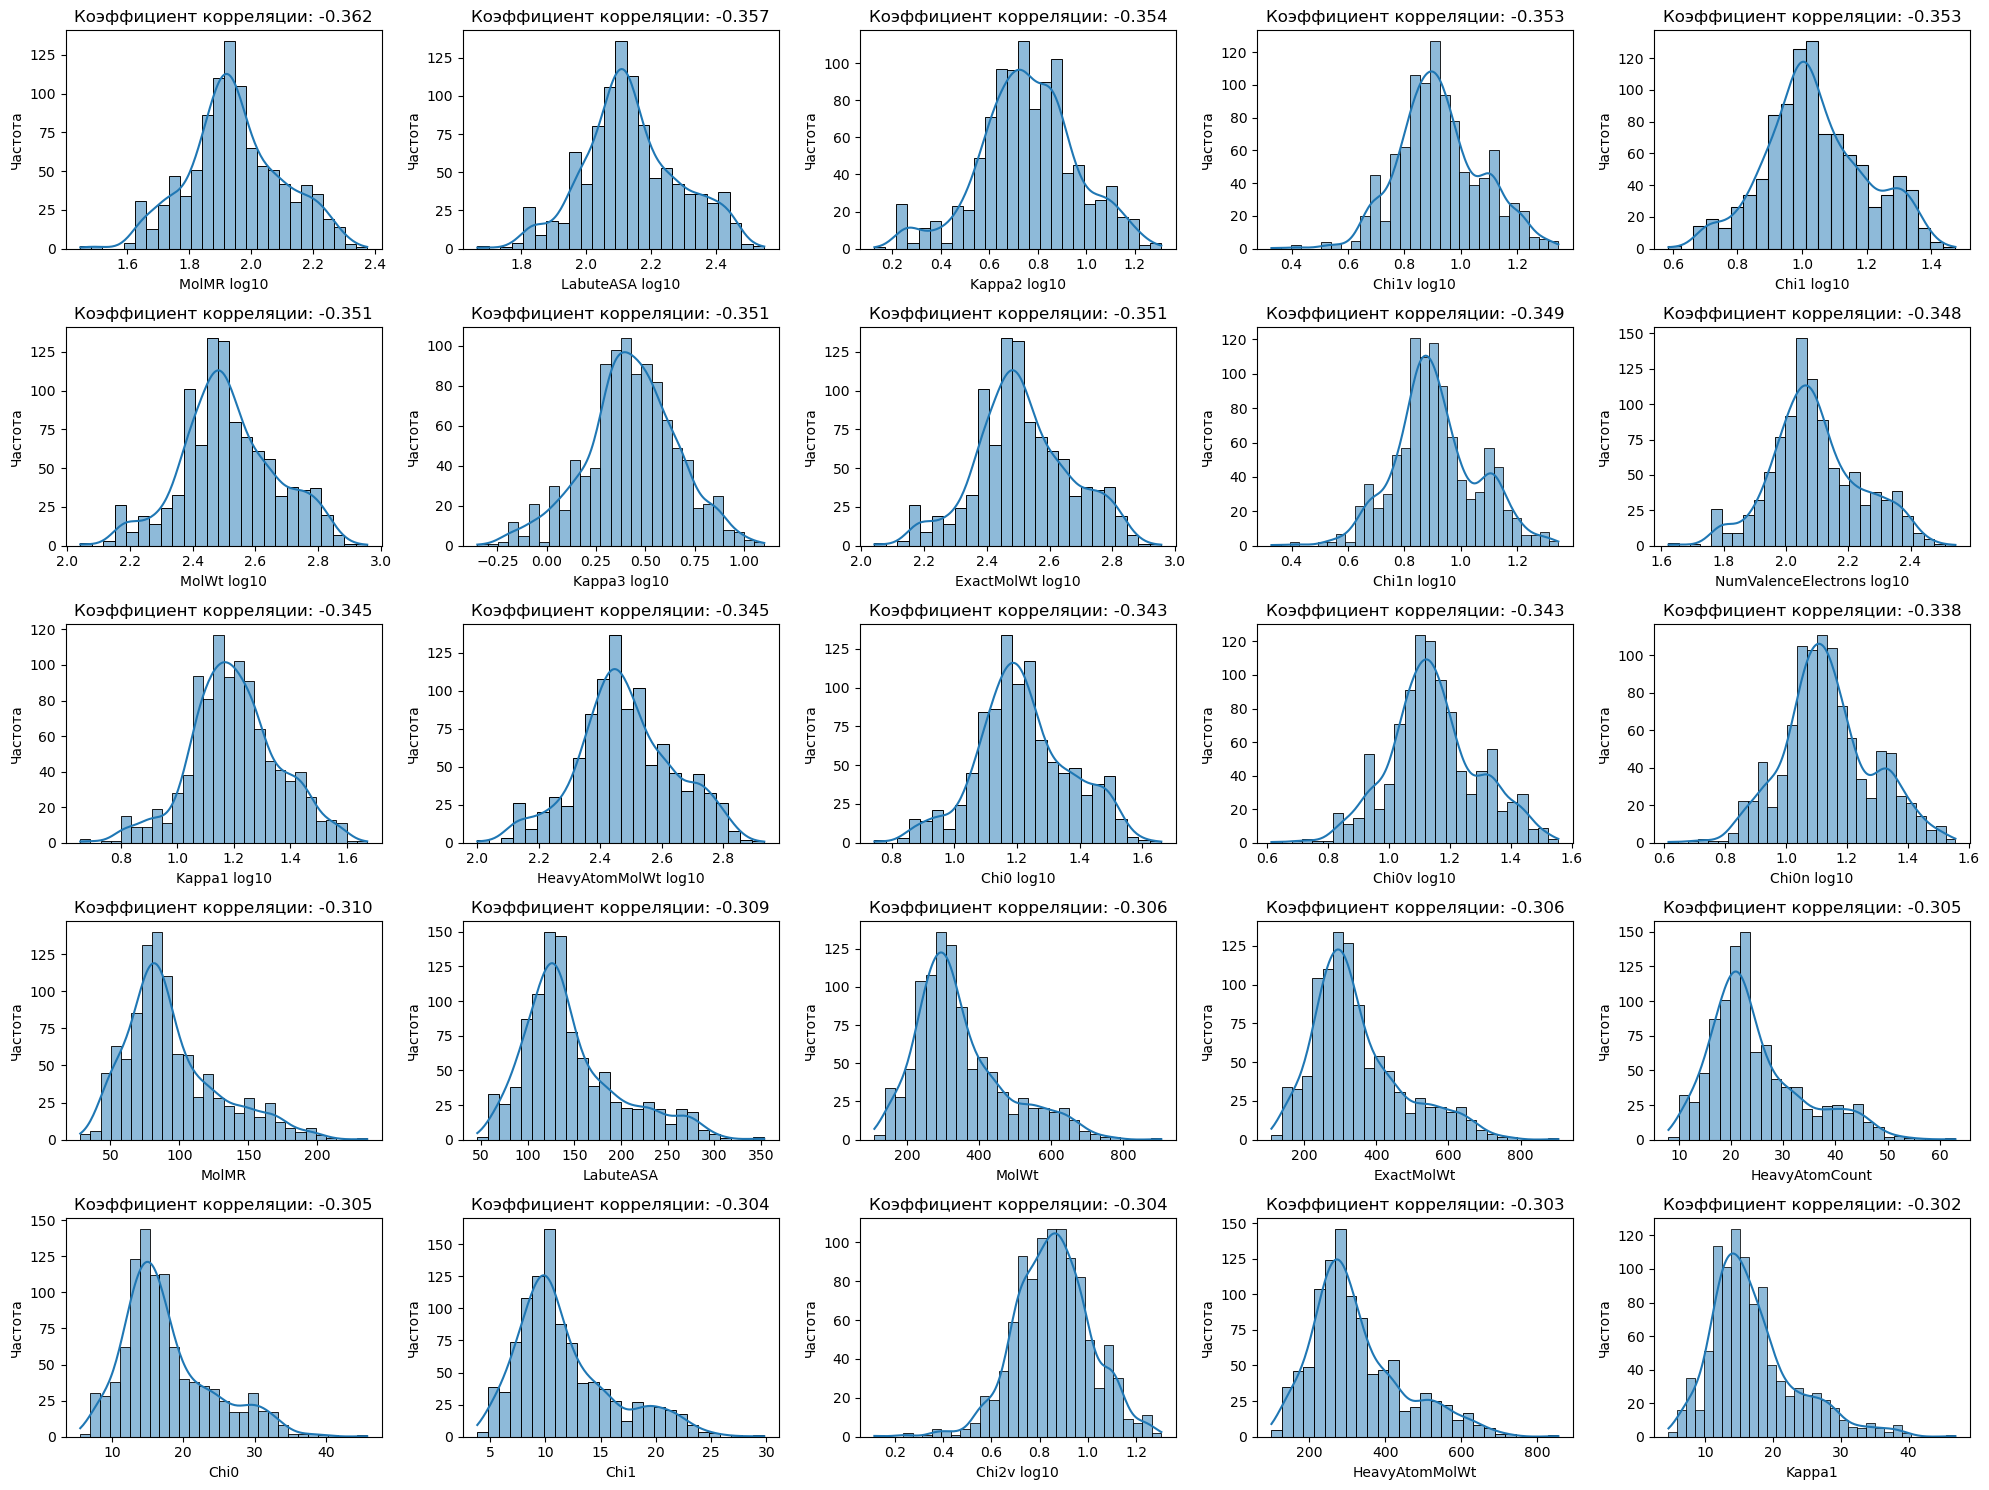

In [208]:
variable_names = list(most_correlated['CC50, mM'].keys())
num_variables = len(variable_names)

# Создаём фигуру и оси для графиков
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()

# Строим графики
for i, variable in enumerate(variable_names):
    ax = axes[i]
    
    # Строим график распределения
    sns.histplot(data[variable], ax=ax, kde=True)
    ax.set_title(f'Коэффициент корреляции: {most_correlated['CC50, mM'][variable]:.3f}')
    ax.set_xlabel(variable)
    ax.set_ylabel('Частота')

# Выводим
plt.tight_layout()
plt.show()

### Корреляции для признака "CC50, mM log10"

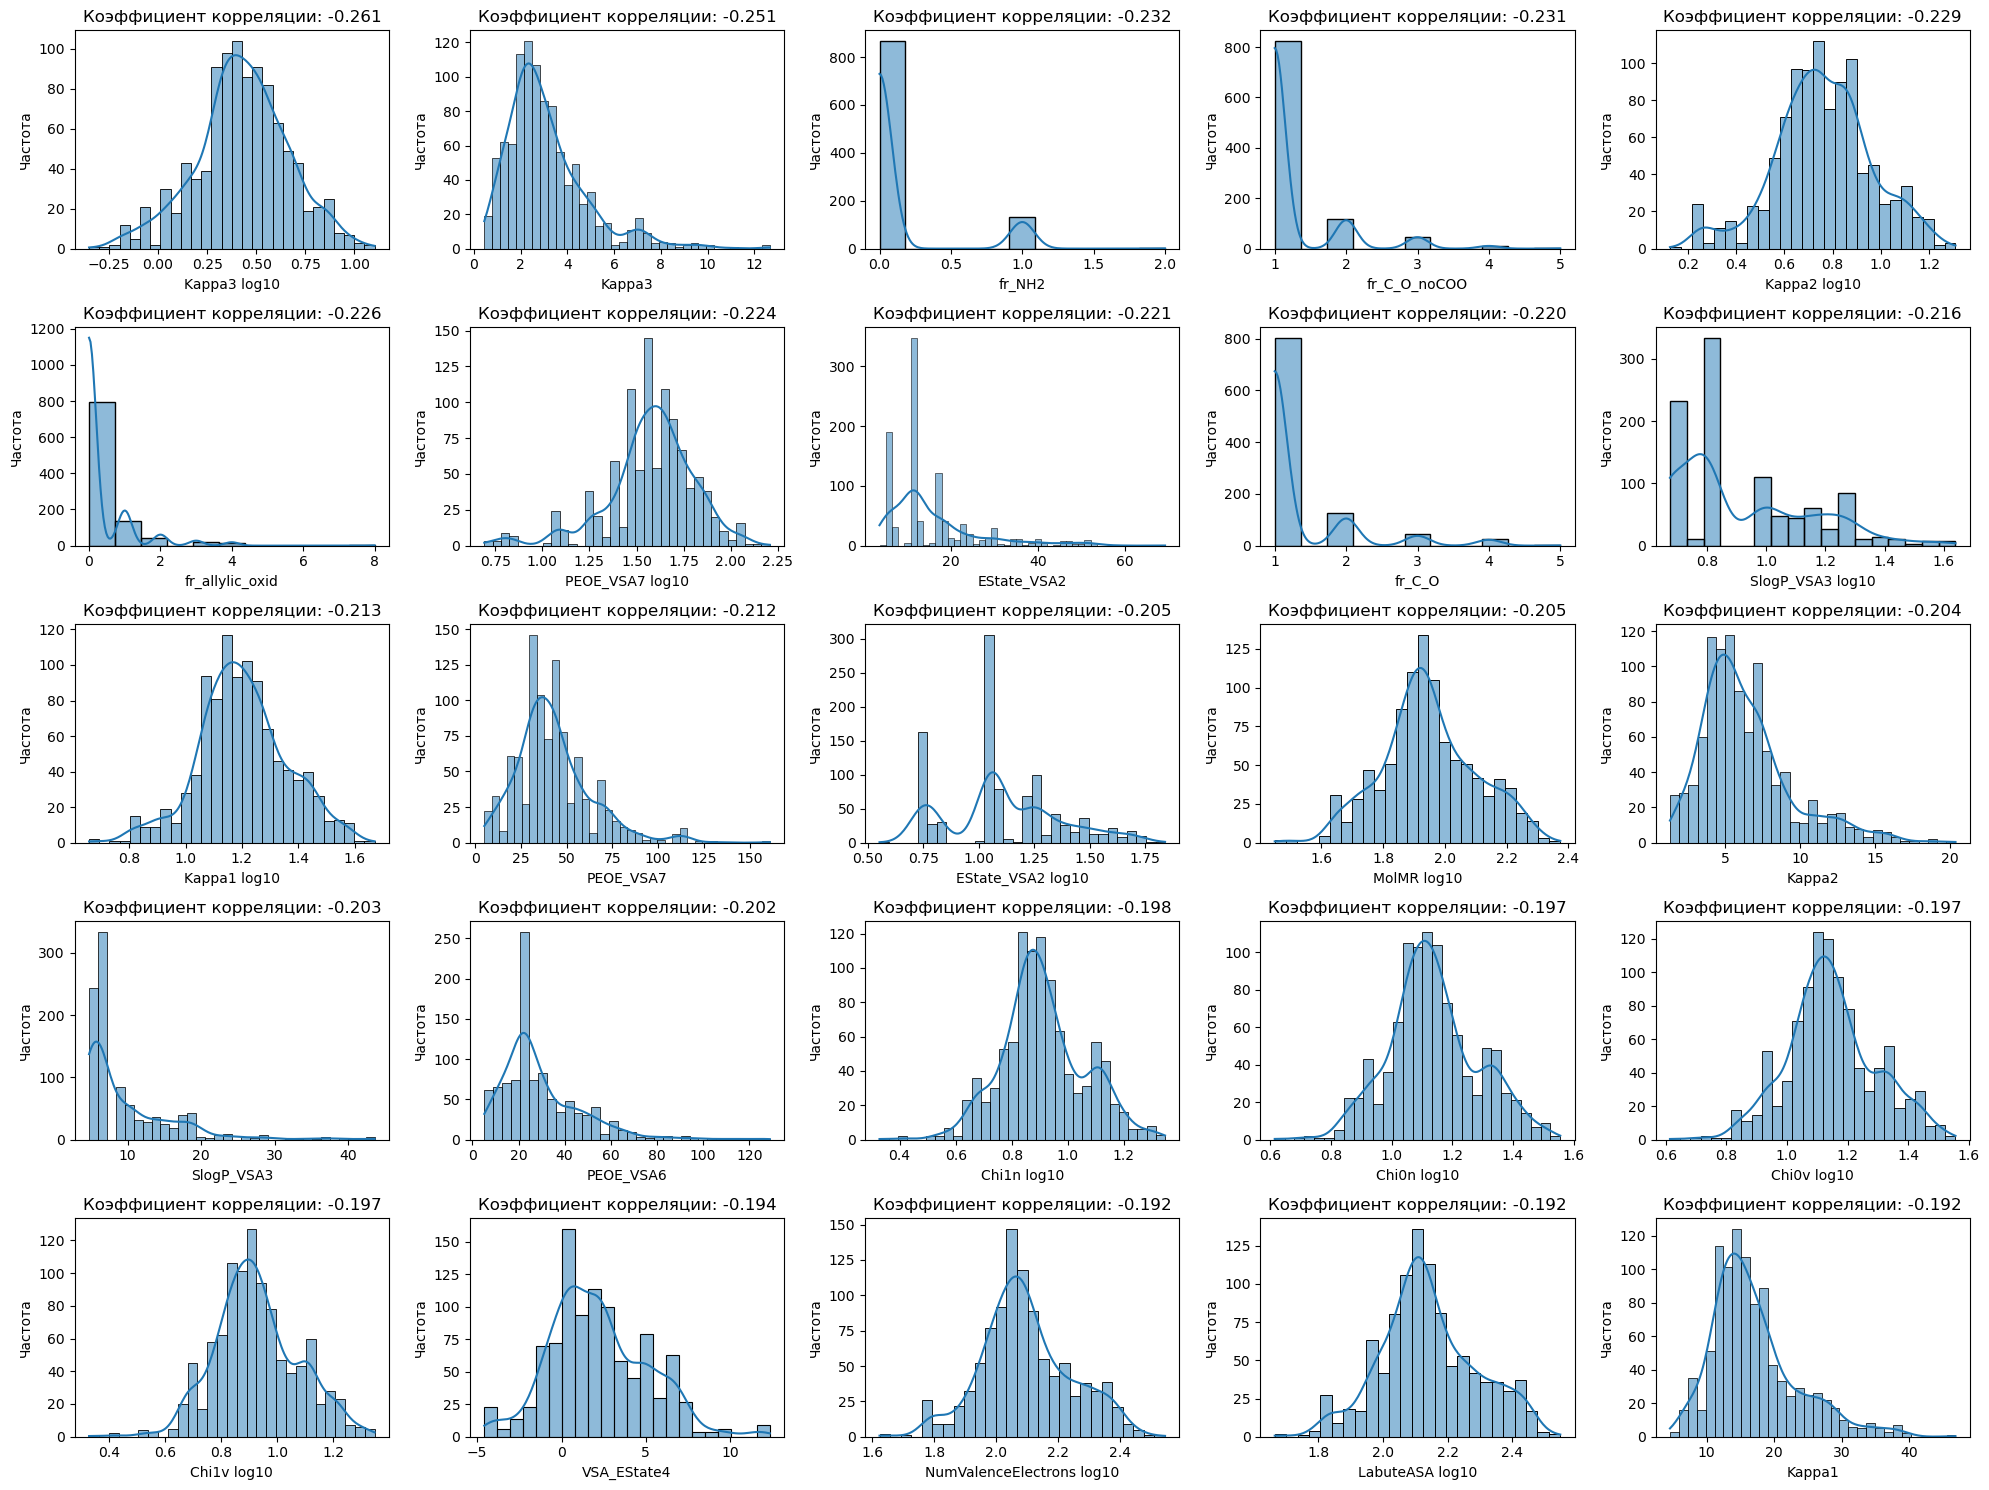

In [210]:
variable_names = list(most_correlated['CC50, mM log10'].keys())
num_variables = len(variable_names)

# Создаём фигуру и оси для графиков
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()

# Строим графики
for i, variable in enumerate(variable_names):
    ax = axes[i]
    
    # Строим график распределения
    sns.histplot(data[variable], ax=ax, kde=True)
    ax.set_title(f'Коэффициент корреляции: {most_correlated['CC50, mM log10'][variable]:.3f}')
    ax.set_xlabel(variable)
    ax.set_ylabel('Частота')

# Выводим
plt.tight_layout()
plt.show()

### Корреляции для признака "SI"

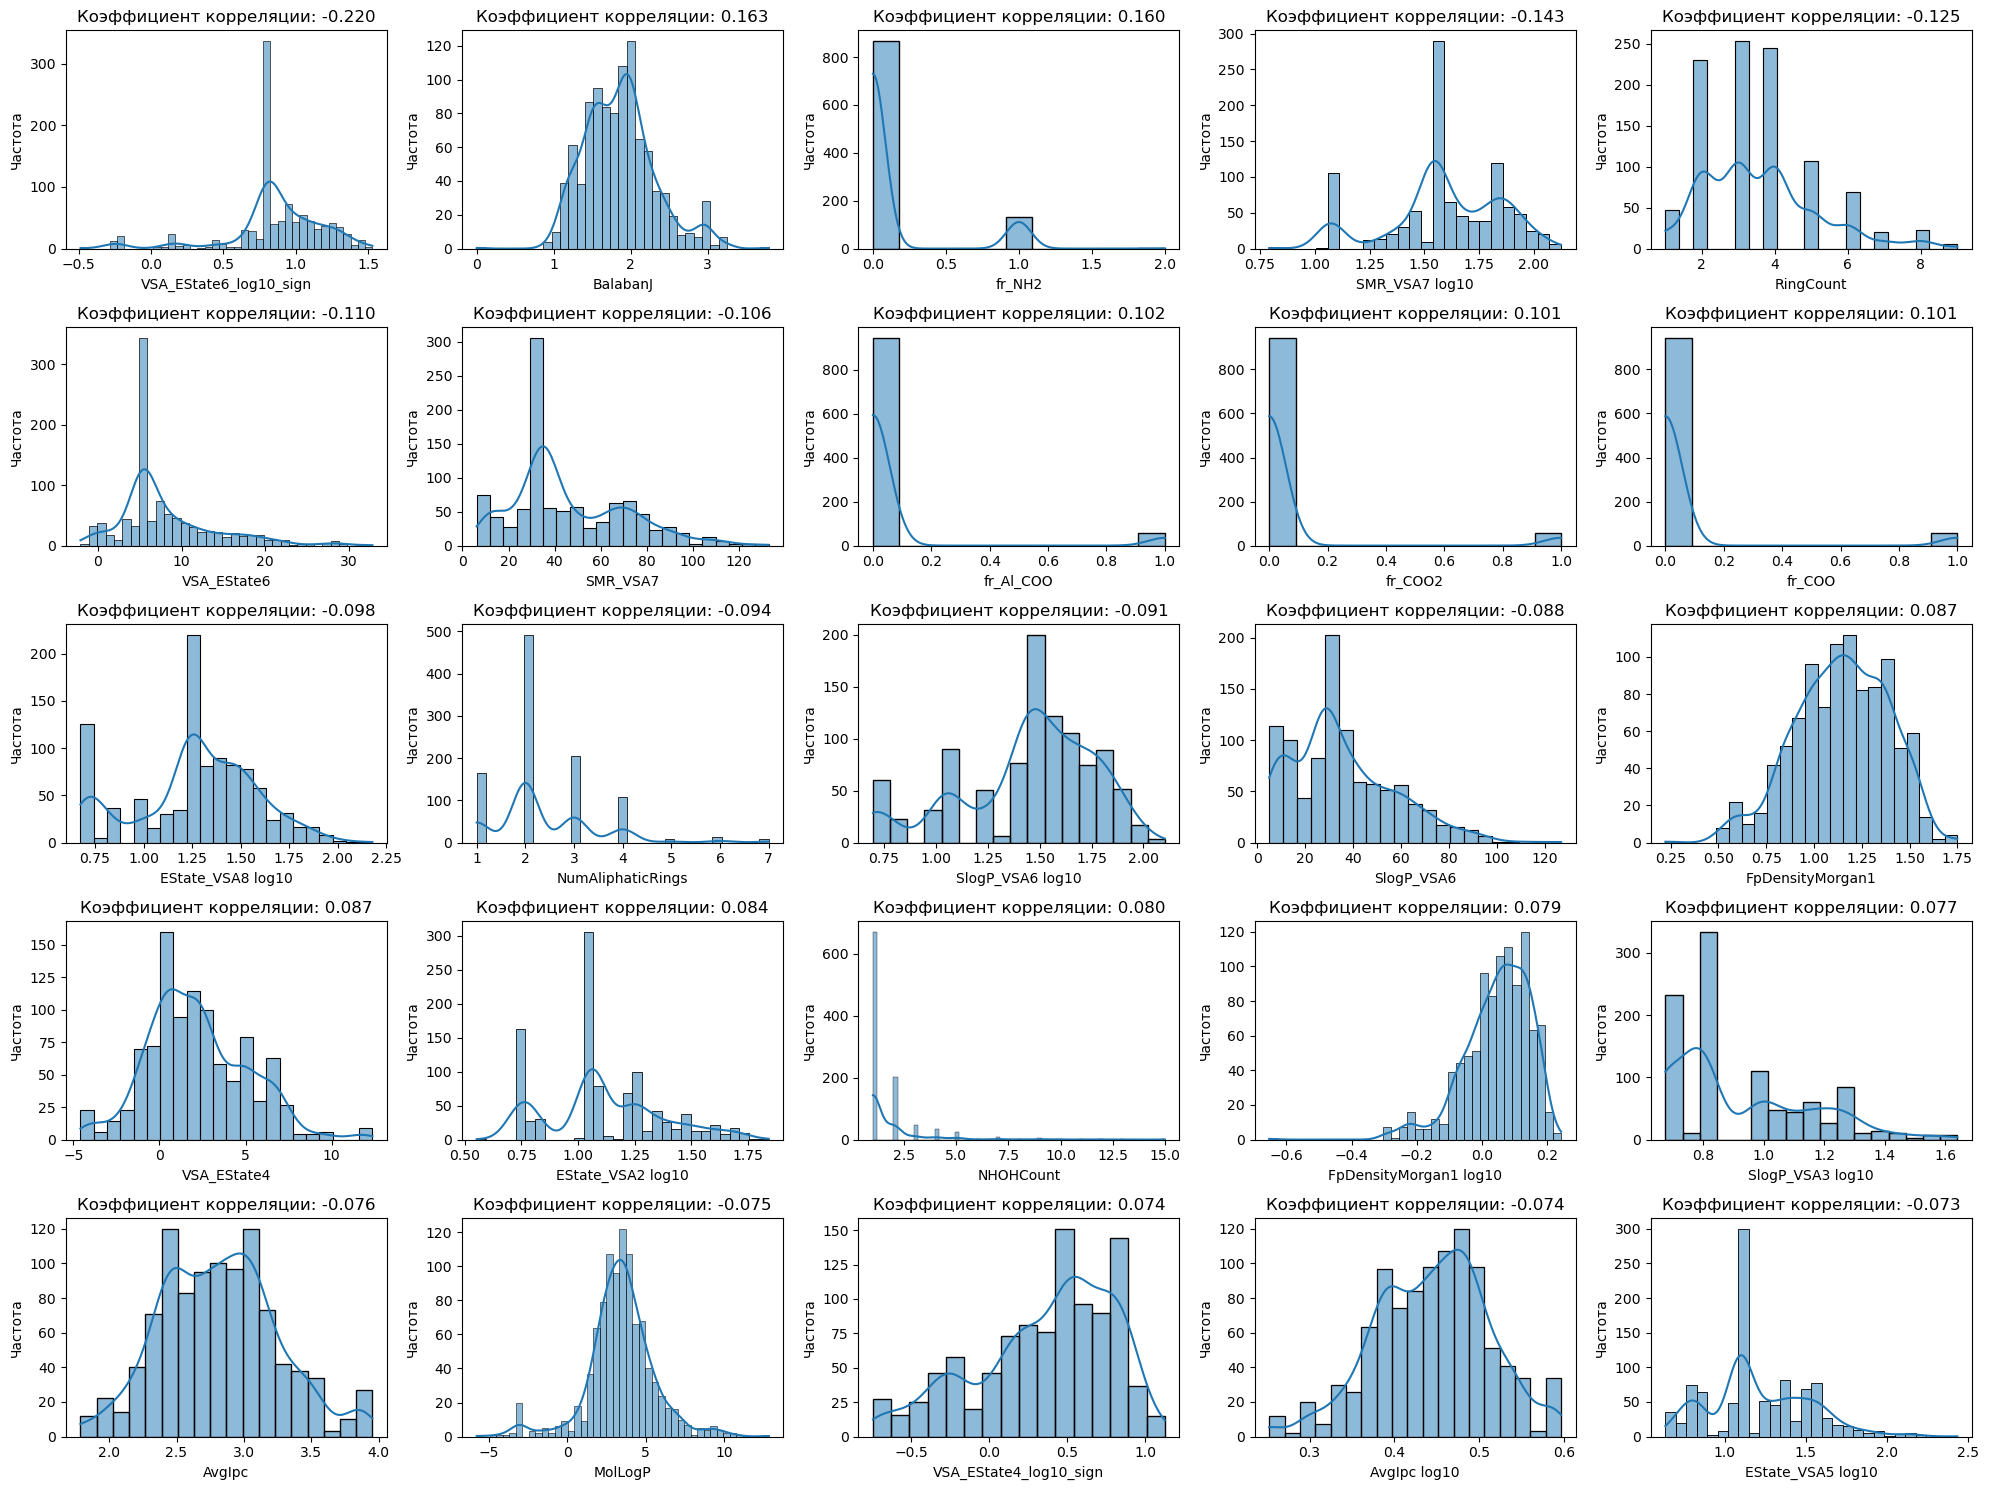

In [212]:
variable_names = list(most_correlated['SI'].keys())
num_variables = len(variable_names)

# Создаём фигуру и оси для графиков
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()

# Строим графики
for i, variable in enumerate(variable_names):
    ax = axes[i]
    
    # Строим график распределения
    sns.histplot(data[variable], ax=ax, kde=True)
    ax.set_title(f'Коэффициент корреляции: {most_correlated['SI'][variable]:.3f}')
    ax.set_xlabel(variable)
    ax.set_ylabel('Частота')

# Выводим
plt.tight_layout()
plt.show()

### Корреляции для признака "SI log10"

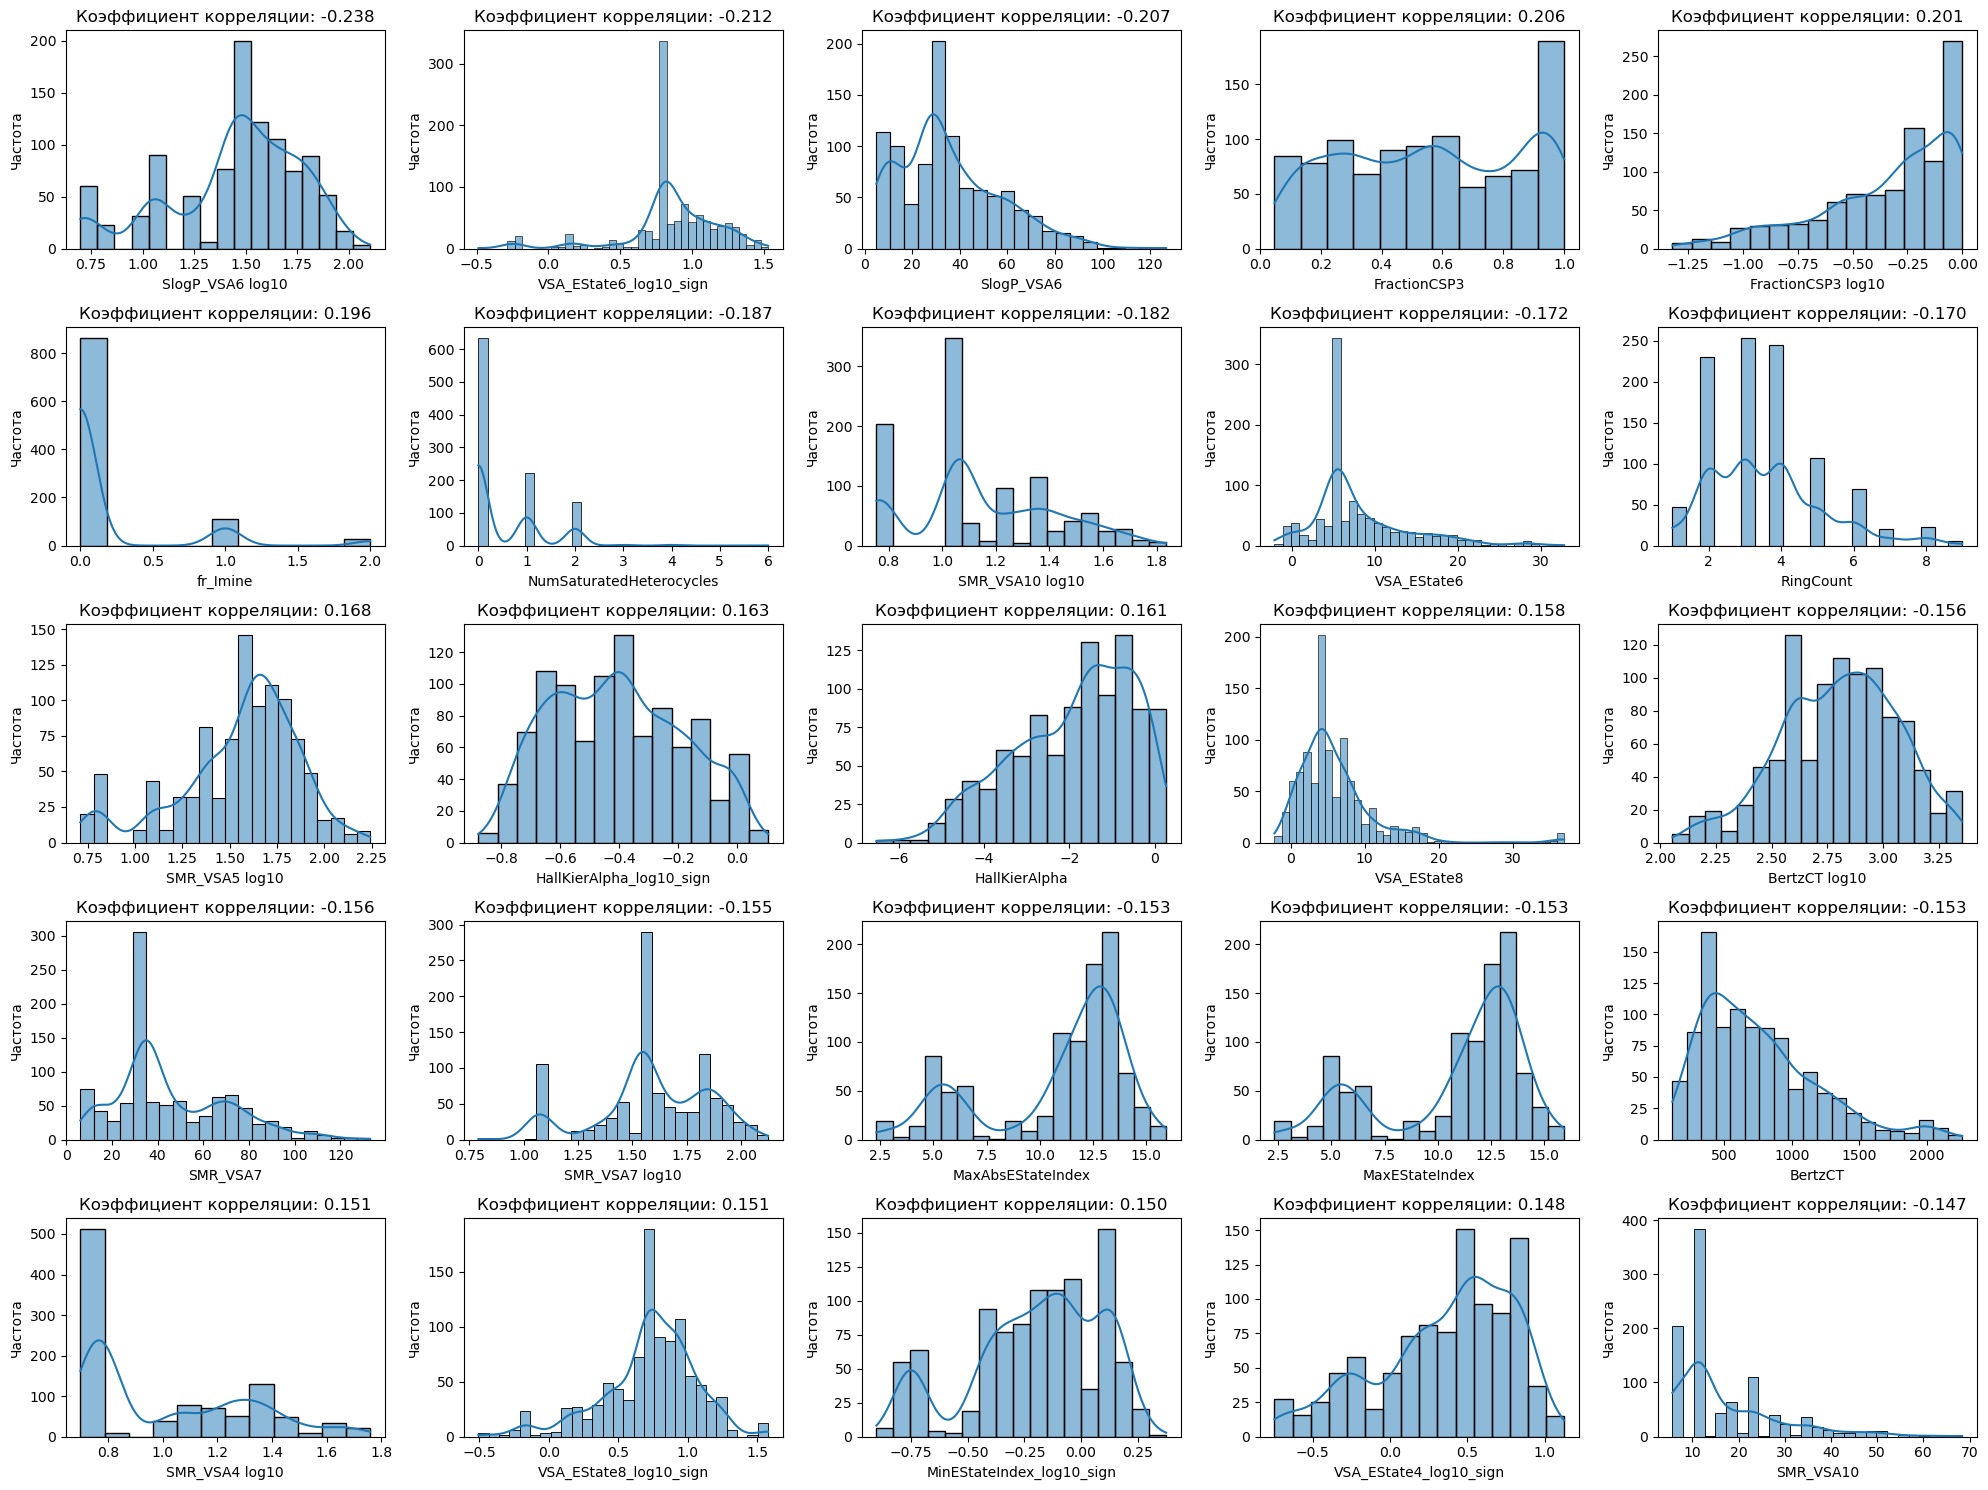

In [214]:
variable_names = list(most_correlated['SI log10'].keys())
num_variables = len(variable_names)

# Создаём фигуру и оси для графиков
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()

# Строим графики
for i, variable in enumerate(variable_names):
    ax = axes[i]
    
    # Строим график распределения
    sns.histplot(data[variable], ax=ax, kde=True)
    ax.set_title(f'Коэффициент корреляции: {most_correlated['SI log10'][variable]:.3f}')
    ax.set_xlabel(variable)
    ax.set_ylabel('Частота')

# Выводим
plt.tight_layout()
plt.show()

### Очистка от признаков с наименьшей корреляцией и сохранение

Для повышения эффективности обучения имеющийся датасет следует разбить на три и очистить от наименее коррелирующих признаков. По датасету на каждый целевой признак. Т.к. при обучении моделей будут использоваться прологарифмированные целевые переменные, то для упрощения дальнейшего анализа признаки SI, CC50 и IC50 учитываться не будут - только SI log10, CC50 log10 и IC50 log10.

In [219]:
# Список целевых переменных
target_columns = ['IC50, mM log10', 'CC50, mM log10', 'SI log10']

# Словарь с 50 самыми наименее коррелирующими для каждого признака
least_correlated = {}

# Цикл, в котором проходим по каждому признаку
for target in target_columns:
    # Считаем корреляции с остальными столбцами (исключая целевые)
    correlations = data.corr()[target].drop(labels=target_columns)
    # Сортируем по абсолютному значению корреляции по возрастанию и берем top-50
    bottom_correlations = correlations.abs().sort_values(ascending=True).head(50)
    # Сохраняем имена и значения корреляций
    least_correlated[target] = correlations.loc[bottom_correlations.index]

# Вывод
for target, corrs in least_correlated.items():
    print(f'\nДля "{target}" наименее коррелируют следующие 50 столбцов:')
    for col, value in corrs.items():
        print(f'  {col}: коэффициент корреляции {value:.3f}')


Для "IC50, mM log10" наименее коррелируют следующие 50 столбцов:
  fr_oxime: коэффициент корреляции 0.001
  VSA_EState2: коэффициент корреляции -0.001
  NumSaturatedRings: коэффициент корреляции -0.003
  BCUT2D_MRHI: коэффициент корреляции 0.003
  fr_hdrzone: коэффициент корреляции -0.004
  MinAbsEStateIndex: коэффициент корреляции 0.004
  SlogP_VSA2 log10: коэффициент корреляции 0.005
  PEOE_VSA1: коэффициент корреляции -0.005
  fr_thiazole: коэффициент корреляции -0.005
  fr_sulfone: коэффициент корреляции 0.007
  fr_aldehyde: коэффициент корреляции 0.008
  VSA_EState3: коэффициент корреляции -0.010
  Ipc log10: коэффициент корреляции -0.010
  SMR_VSA1 log10: коэффициент корреляции 0.010
  VSA_EState5_log10_sign: коэффициент корреляции -0.010
  fr_oxazole: коэффициент корреляции 0.011
  fr_amide: коэффициент корреляции -0.012
  MaxAbsPartialCharge: коэффициент корреляции -0.012
  BCUT2D_MRHI log10: коэффициент корреляции -0.012
  BCUT2D_MWHI: коэффициент корреляции 0.013
  fr_benzen

Далее разделяем и очищаем датасеты.

In [276]:
# Разделяем датасет
IC50_data = data.copy()
CC50_data = data.copy()
SI_data = data.copy()

In [278]:
# Очистка IC50_data
columns_to_drop = list(least_correlated['IC50, mM log10'].keys())
additional_columns = ['IC50, mM', 'CC50, mM', 'SI', 'CC50, mM log10', 'SI log10']
columns_to_drop.extend(additional_columns)

IC50_data = IC50_data.drop(columns=columns_to_drop)

# Сохранение
IC50_data.to_csv('IC50_data.csv', index=False)

# Проверка
IC50_data.head(10)

,"IC50, mM log10",MaxAbsEStateIndex,MaxAbsEStateIndex log10,MaxEStateIndex,MaxEStateIndex log10,MinAbsEStateIndex log10,MinEStateIndex,MinEStateIndex_log10_sign,SPS,SPS log10,...,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfonamd,fr_term_acetylene,fr_tetrazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.795141,5.094096,0.707067,5.094096,0.707067,-0.412037,0.387225,0.142147,42.928571,1.632746,...,0,0,0,0,0,0,0,0,3,0
1,-0.112478,3.961417,0.597851,3.961417,0.597851,-0.272566,0.533868,0.185788,45.214286,1.655276,...,0,0,0,0,0,0,0,0,3,0
2,2.349877,2.627117,0.419479,2.627117,0.419479,-0.265016,0.543231,0.188431,42.187500,1.625184,...,0,0,0,2,0,0,0,0,3,0
3,0.231883,5.097360,0.707345,5.097360,0.707345,-0.408265,0.390603,0.143203,41.862069,1.621821,...,0,0,0,0,0,0,0,0,4,0
4,2.029917,5.150510,0.711850,5.150510,0.711850,-0.567871,0.270476,0.103966,36.514286,1.562463,...,0,0,0,0,0,0,0,0,0,0
5,1.177187,5.758408,0.760302,5.758408,0.760302,-0.555826,0.278083,0.106559,28.600000,1.456366,...,0,0,0,0,0,0,0,0,0,0
6,1.276649,2.584472,0.412372,2.584472,0.412372,-0.366886,0.429649,0.155230,36.564103,1.563055,...,0,0,0,2,0,0,0,0,0,0
7,1.458986,13.821880,1.140567,13.821880,1.140567,-1.097752,-0.301260,-0.114364,31.333333,1.496007,...,0,0,0,0,0,0,0,0,4,0
8,1.699465,14.171614,1.151419,14.171614,1.151419,-1.718442,-0.411828,-0.149782,29.157895,1.464756,...,0,0,0,0,0,0,0,0,0,0
9,0.806237,6.135893,0.787878,6.135893,0.787878,-0.621192,0.239226,0.093151,36.400000,1.561101,...,0,0,0,0,0,0,0,0,0,0


In [280]:
# Очистка CC50_data
columns_to_drop = list(least_correlated['CC50, mM log10'].keys())
additional_columns = ['IC50, mM', 'CC50, mM', 'SI', 'IC50, mM log10', 'SI log10']
columns_to_drop.extend(additional_columns)

CC50_data = CC50_data.drop(columns=columns_to_drop)

# Сохранение
CC50_data.to_csv('CC50_data.csv', index=False)

# Проверка
CC50_data.head(10)

,"CC50, mM log10",MaxAbsEStateIndex,MaxAbsEStateIndex log10,MaxEStateIndex,MaxEStateIndex log10,MinAbsEStateIndex,MinAbsEStateIndex log10,MinEStateIndex,qed,qed log10,...,fr_piperdine,fr_piperzine,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_term_acetylene,fr_tetrazole,fr_thiophene,fr_urea
0,2.244234,5.094096,0.707067,5.094096,0.707067,0.387225,-0.412037,0.387225,0.417362,-0.379487,...,0,0,0,0,0,0,0,0,0,0
1,0.732620,3.961417,0.597851,3.961417,0.597851,0.533868,-0.272566,0.533868,0.462473,-0.334914,...,0,0,0,0,0,0,0,0,0,0
2,2.207210,2.627117,0.419479,2.627117,0.419479,0.543231,-0.265016,0.543231,0.260923,-0.583488,...,0,0,0,2,0,0,0,0,0,0
3,2.032843,5.097360,0.707345,5.097360,0.707345,0.390603,-0.408265,0.390603,0.377846,-0.422686,...,0,0,0,0,0,0,0,0,0,0
4,2.143861,5.150510,0.711850,5.150510,0.711850,0.270476,-0.567871,0.270476,0.429038,-0.367504,...,0,0,0,0,0,0,0,0,0,0
5,1.478217,5.758408,0.760302,5.758408,0.760302,0.278083,-0.555826,0.278083,0.711012,-0.148123,...,0,0,0,0,0,0,0,0,0,0
6,1.163140,2.584472,0.412372,2.584472,0.412372,0.429649,-0.366886,0.429649,0.328539,-0.483413,...,0,0,0,2,0,0,0,0,0,0
7,1.372800,13.821880,1.140567,13.821880,1.140567,0.079845,-1.097752,-0.301260,0.217332,-0.662876,...,0,0,0,0,0,0,0,0,0,0
8,2.186700,14.171614,1.151419,14.171614,1.151419,0.019123,-1.718442,-0.411828,0.187781,-0.726347,...,0,0,0,0,0,0,0,0,0,0
9,2.603043,6.135893,0.787878,6.135893,0.787878,0.239226,-0.621192,0.239226,0.439915,-0.356631,...,0,0,0,0,0,0,0,0,0,0


In [282]:
# Очистка SI_data
columns_to_drop = list(least_correlated['SI log10'].keys())
additional_columns = ['IC50, mM', 'CC50, mM', 'SI', 'IC50, mM log10', 'CC50, mM log10']
columns_to_drop.extend(additional_columns)

SI_data = SI_data.drop(columns=columns_to_drop)

# Сохранение
SI_data.to_csv('SI_data.csv', index=False)

# Проверка
SI_data.head(10)

,SI log10,MaxAbsEStateIndex,MaxAbsEStateIndex log10,MaxEStateIndex,MaxEStateIndex log10,MinAbsEStateIndex,MinEStateIndex,MinEStateIndex_log10_sign,qed,qed log10,...,fr_piperdine,fr_piperzine,fr_priamide,fr_quatN,fr_sulfide,fr_sulfonamd,fr_tetrazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.449093,5.094096,0.707067,5.094096,0.707067,0.387225,0.387225,0.142147,0.417362,-0.379487,...,0,0,0,0,0,0,0,0,3,0
1,0.845098,3.961417,0.597851,3.961417,0.597851,0.533868,0.533868,0.185788,0.462473,-0.334914,...,0,0,0,0,0,0,0,0,3,0
2,-0.142668,2.627117,0.419479,2.627117,0.419479,0.543231,0.543231,0.188431,0.260923,-0.583488,...,0,0,0,2,0,0,0,0,3,0
3,1.800960,5.097360,0.707345,5.097360,0.707345,0.390603,0.390603,0.143203,0.377846,-0.422686,...,0,0,0,0,0,0,0,0,4,0
4,0.113943,5.150510,0.711850,5.150510,0.711850,0.270476,0.270476,0.103966,0.429038,-0.367504,...,0,0,0,0,0,0,0,0,0,0
5,0.301030,5.758408,0.760302,5.758408,0.760302,0.278083,0.278083,0.106559,0.711012,-0.148123,...,0,0,0,0,0,0,0,0,0,0
6,-0.113509,2.584472,0.412372,2.584472,0.412372,0.429649,0.429649,0.155230,0.328539,-0.483413,...,0,0,0,2,0,0,0,0,0,0
7,-0.086186,13.821880,1.140567,13.821880,1.140567,0.079845,-0.301260,-0.114364,0.217332,-0.662876,...,0,0,0,0,0,0,0,0,4,0
8,0.487235,14.171614,1.151419,14.171614,1.151419,0.019123,-0.411828,-0.149782,0.187781,-0.726347,...,0,0,0,0,0,0,0,0,0,0
9,1.796806,6.135893,0.787878,6.135893,0.787878,0.239226,0.239226,0.093151,0.439915,-0.356631,...,0,0,0,0,0,0,0,0,0,0
